In [109]:
from typing import Iterable
import datetime
from collections import Counter
import statistics

In [79]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdDepictor
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS
# from rdkit.Chem.Draw import IPythonConsole
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print(rdkit.__version__)

2023.09.1


In [3]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [4]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [5]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n OR keep all rows for a Ref, putting all the SMILES into a set 
2) For each row corresponding to a Ref,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [6]:
file_name = "../data/Tautomer_database_release_3a.xlsx"
# file_name = "../data/Tautomer_database_release_3a_first.xlsx"
sheet_name = "Tautomer_database"
# file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [7]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [8]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

numbered_columns = []
for i, SMILES_column in enumerate(SMILES_columns):
    numbered_columns.append(SMILES_column)
    numbered_columns.append(InChI_columns[i])

df = df.select("Ref","Size",*numbered_columns)
print(df.sort("Ref"))
print(df.filter(pl.col("Ref") == 4))
df_melted = df.melt(id_vars=["Ref","Size"], value_vars=SMILES_columns[:2], value_name="sml")
df_melted
df_melted = df_melted.filter(pl.col('sml').is_not_null())

df_melted = df_melted.drop("variable")
df_melted = df_melted.unique()
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: Chem.MolFromSmiles(s)).alias("mol"),
    ]
)

df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)
print("df_melted, Ref=4")
print(df_melted.filter(pl.col("Ref") == 4))

df_melted = df_melted.drop("sml").drop_nulls()
df_melted = df_melted.unique("canon_sml")

df_melted = df_melted.sort("Ref")
with pl.Config(fmt_str_lengths=1000):
    print(df_melted)

shape: (2_820, 12)
┌──────┬──────┬───────────────┬──────────────┬───┬──────────┬─────────────┬──────────┬─────────────┐
│ Ref  ┆ Size ┆ SMILES_1      ┆ Std_InChI_1  ┆ … ┆ SMILES_4 ┆ Std_InChI_4 ┆ SMILES_5 ┆ Std_InChI_5 │
│ ---  ┆ ---  ┆ ---           ┆ ---          ┆   ┆ ---      ┆ ---         ┆ ---      ┆ ---         │
│ i64  ┆ i64  ┆ str           ┆ str          ┆   ┆ str      ┆ str         ┆ str      ┆ str         │
╞══════╪══════╪═══════════════╪══════════════╪═══╪══════════╪═════════════╪══════════╪═════════════╡
│ null ┆ null ┆ null          ┆ null         ┆ … ┆ null     ┆ null        ┆ null     ┆ null        │
│ 1    ┆ 2    ┆ O=C(C)CC(C)=O ┆ InChI=1S/C5H ┆ … ┆ null     ┆ null        ┆ null     ┆ null        │
│      ┆      ┆               ┆ 8O2/c1-4(6)3 ┆   ┆          ┆             ┆          ┆             │
│      ┆      ┆               ┆ -5(2)7/h…    ┆   ┆          ┆             ┆          ┆             │
│ 1    ┆ 2    ┆ C/C(O)=C/C(C) ┆ InChI=1S/C5H ┆ … ┆ null     ┆ null      

In [9]:
df_melted.filter(pl.col("Ref") == 4)

Ref,Size,mol,canon_sml
i64,i64,object,str


In [10]:
def smls_tauts(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [11]:
def tauts_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_list = []
    for taut in tauts:
        tauts_list.append(taut)
    return tauts_list

In [12]:
def tauts_as_sml_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

In [13]:
# Enumerate tautomers
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_as_sml_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )
df_melted.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator
i64,i64,object,str,list[str],list[str]
1,2,<rdkit.Chem.rdchem.Mol object at 0x1338faf80>,"""CC(=O)/C=C(/C)…","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]"
1,2,<rdkit.Chem.rdchem.Mol object at 0x135890190>,"""CC(=O)CC(C)=O""","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]"
2,2,<rdkit.Chem.rdchem.Mol object at 0x13582d000>,"""c1cn[nH]n1""","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]"


In [24]:
# Merge tautomer smls for each row for same ref: 
#   assumption is that all input smls correspond to legitimate tautomers
other_columns = [col for col in df_melted.columns if col not in ['Ref']]

df_melted_aggregated = (
    df_melted.group_by('Ref')
    .agg(*other_columns)
)
df_melted_aggregated.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]"
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]"
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""], [""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]]"


In [25]:
def list_2D_to_unique_list(
        list_2D: list[list]
) -> list:
    # Flatten lists
    list_flat = [item for sublist in list_2D for item in (sublist if isinstance(sublist, list) else [sublist])]

    # Convert to set to eliminate duplicates, then back to list to store in dataframe
    list_flat_unique = list(set(list_flat))
    print(f"list_2D_to_unique_list returning {list_flat_unique}")
#     return [77]
    return list_flat_unique

In [26]:
tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('tauts')]
for tauts_column in tauts_columns:
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(tauts_column).map_elements(lambda m: list(set([item for row in m for item in row]))).alias("flat_" + tauts_column),
        ]
    )
df_melted_aggregated.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[str],list[str]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]"
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]"
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""], [""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]"


Hi

In [27]:
# Add tautomer counts
flat_tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('flat_tauts')]
for flat_tauts_column in flat_tauts_columns:
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(flat_tauts_column).map_elements(lambda t: len(t)).alias("n_" + flat_tauts_column.replace("flat_", "")),
        ]
    )
df_melted_aggregated.drop(["tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).head(3)

Ref,Size,mol,canon_sml,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator
i64,list[i64],list[extension],list[str],list[str],list[str],i64,i64
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",2,2
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]",2,5


In [28]:
def sets_are_equal(
        *iterables: Iterable,
):
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            return False  # Return False if keys are not the same
    return True  # Return True if all dictionaries have the same keys

In [29]:
# Check if sets of tautomers are the same for different algorithms
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
        # Check if different algos produce same set of tautomers
        pl.struct(["flat_tautsTautomerEnumerator", "flat_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: sets_are_equal(x["flat_tautsTautomerEnumerator"], x["flat_tautsGetV1TautomerEnumerator"]))
        .alias("tauts_same"),
        # Calculate difference in number of tautomers between algos
        pl.struct(["n_tautsTautomerEnumerator", "n_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: x["n_tautsTautomerEnumerator"] - x["n_tautsGetV1TautomerEnumerator"])
        .alias("n_tauts_diff"),
    ]
)
df_melted_aggregated.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[str],list[str],i64,i64,bool,i64
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""CC(=O)/C=C(/C)O"", ""CC(=O)CC(C)=O""]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""CC(=O)C=C(C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",5,5,true,0
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""c1cn[nH]n1"", ""c1c[nH]nn1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",2,2,true,0
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""], [""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]]","[[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""], [""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]]","[""Cc1cc[nH]n1"", ""Cc1ccn[nH]1""]","[""CC1=NN=CC1"", ""C=C1CC=NN1"", … ""Cc1ccn[nH]1""]",2,5,false,-3


In [31]:
# Narrow down to rows where algos give different sets of tautomers
df_melted_aggregated_different = df_melted_aggregated.filter(pl.col("tauts_same") == False)

df_melted_aggregated_different.drop(["mol","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(abs(pl.col("n_tauts_diff")) < 5).sort(abs(pl.col("n_tauts_diff")), descending=True).head(7)

Ref,Size,canon_sml,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same,n_tauts_diff
i64,list[i64],list[str],list[str],list[str],i64,i64,bool,i64
73,"[2, 2]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]",4,8,false,-4
76,"[2, 2]","[""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1"", ""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1""]","[""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1"", ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1"", … ""CCOC(=O)C1C(C)=NC(OC)=NC1c1ccccc1""]","[""CCOC(O)=C1C(C)=NC(OC)=NC1c1ccccc1"", ""C=C1N=C(OC)NC(c2ccccc2)C1C(=O)OCC"", … ""CCOC(=O)C1C(C)=NC(OC)=NC1c1ccccc1""]",4,8,false,-4
77,"[2, 2]","[""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1Cl"", ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1Cl""]","[""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1Cl"", ""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1Cl"", … ""CCOC(=O)C1C(C)=NC(OC)=NC1c1ccccc1Cl""]","[""CCOC(=O)C1C(C)=NC(OC)=NC1c1ccccc1Cl"", ""C=C1NC(OC)=NC(c2ccccc2Cl)C1C(=O)OCC"", … ""C=C1N=C(OC)NC(c2ccccc2Cl)C1C(=O)OCC""]",4,8,false,-4
80,"[2, 2]","[""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])NC(C(F)(F)F)=N1"", ""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N=C(C(F)(F)F)N1""]","[""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])NC(C(F)(F)F)=N1"", ""CC1=NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", … ""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N=C(C(F)(F)F)N1""]","[""CC1=NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""CC1=NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", … ""C=C1NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C""]",4,8,false,-4
115,"[2, 2]","[""NC1=c2c(nc3n2Cc2ccccc2-3)=NS(=O)(=O)N1"", ""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3""]","[""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3"", ""NC1=c2c(nc3n2Cc2ccccc2-3)=NS(=O)(=O)N1"", ""N=C1NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3""]","[""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3"", ""NC1=c2c(nc3c4ccccc4cn23)NS(=O)(=O)N1"", … ""NC1=NS(=O)(=O)Nc2[nH]c3c4ccccc4cn3c21""]",3,7,false,-4
149,"[3, 3]","[""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12""]","[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)C1C=Nn2c1ncc(-c1nc3ccccc3[nH]c1=O)c2=O"", … ""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4N=C3O)cnc12""]","[""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", … ""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4N=C3O)cnc12""]",14,10,false,4
151,"[3, 3]","[""COC(=O)c1c(N)nn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12"", ""COC(=O)c1c(N)[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]","[""COC(=O)c1c(N)nn2c(O)c(-c3nc4ccccc4nc3O)cnc12"", ""COC(=O)c1c(=N)[nH]n2c(O)c(-c3nc4ccccc4nc3O)cnc12"", … ""COC(=O)c1c(N)nn2c(=O)c(=C3Nc4ccccc4NC3=O)cnc12""]","[""COC(=O)c1c(N)nn2c(O)c(-c3nc4ccccc4nc3O)cnc12"", ""COC(=O)c1c(=N)[nH]n2c(O)c(-c3nc4ccccc4nc3O)cnc12"", … ""COC(=O)c1c(N)nn2c(=O)c(=C3Nc4ccccc4NC3=O)cnc12""]",26,22,false,4


In [87]:
def second_highest_frequency(lst):
    # Count frequencies of elements in the list
    frequencies = Counter(lst)
    
    # Find the second highest frequency
    unique_frequencies = sorted(set(frequencies.values()), reverse=True)
    
    # Find the second highest frequency value(s)
    second_highest_freq = unique_frequencies[1] if len(unique_frequencies) > 1 else unique_frequencies[0]
        
    return second_highest_freq

In [112]:
n_tauts_diff = df_melted_aggregated["n_tauts_diff"].to_list()
n_tauts_diff_no_zeros = [diff for diff in n_tauts_diff if diff != 0]
n_tauts_diff_positive = [diff for diff in n_tauts_diff_no_zeros if diff > 0]
n_tauts_diff_negative = [diff for diff in n_tauts_diff_no_zeros if diff < 0]
print(f"{len(n_tauts_diff)=}")
print(f"{len(n_tauts_diff_no_zeros)=}")
print(f"{len(n_tauts_diff_positive)=}")
print(f"{len(n_tauts_diff_negative)=}")

statistics.mean(n_tauts_diff)

len(n_tauts_diff)=1763
len(n_tauts_diff_no_zeros)=545
len(n_tauts_diff_positive)=135
len(n_tauts_diff_negative)=410


-4.608621667612025

In [158]:
def stats_for_list(
        my_list
):
    stats = {"mean":statistics.mean(my_list), "median":statistics.median(my_list), "mode":statistics.mode(my_list), "std dev":statistics.stdev(my_list)}
    for stat, value in stats.items():
        if stat in ["mean", "std dev"]:
            print(f"{stat:10} {value:.2f}")
        else:
            print(f"{stat:10} {value:}")
    return stats

In [159]:
stats_for_list(n_tauts_diff_no_zeros)

mean       -14.91
median     -2
mode       -1
std dev    52.49


{'mean': -14.908256880733944,
 'median': -2,
 'mode': -1,
 'std dev': 52.48503660785623}

In [160]:
stats_for_list(n_tauts_diff_positive)

mean       7.00
median     1
mode       1
std dev    28.42


{'mean': 7, 'median': 1, 'mode': 1, 'std dev': 28.422452760019187}

In [161]:
stats_for_list(n_tauts_diff_negative)

mean       -22.12
median     -4.0
mode       -1
std dev    56.47


{'mean': -22.121951219512194,
 'median': -4.0,
 'mode': -1,
 'std dev': 56.46826363666076}

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


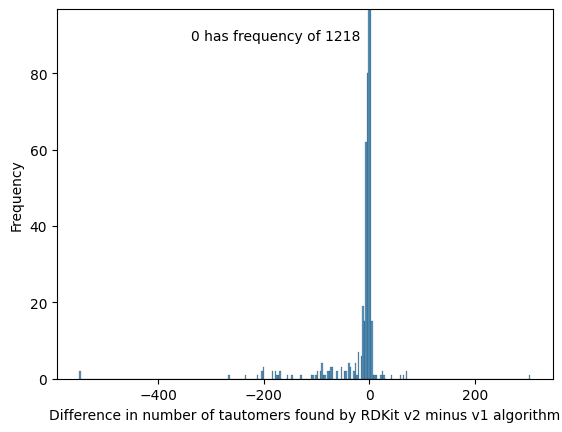

In [147]:
# Plot histogram of n_tauts_diff

sns.histplot(n_tauts_diff, bins=300)  # Adjust bins as needed
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
# plt.title('Histogram using Seaborn')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(0, largest_y_value, f'0 has frequency of {frequency_at_zero}  ', ha='right', va='bottom')

plt.show()


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


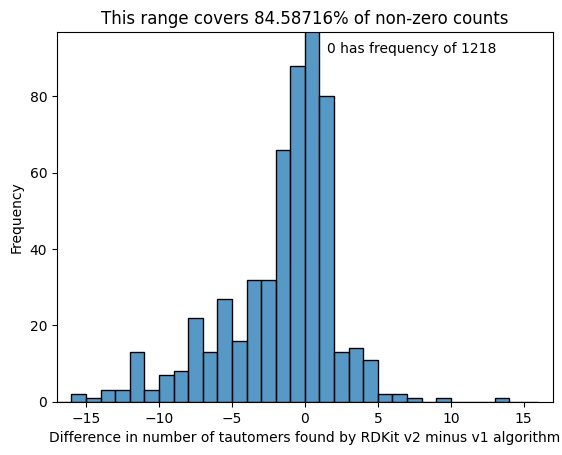

In [140]:
# Plot histogram of n_tauts_diff

x_len = 17
bins = range(-1 * x_len, x_len, 1)

n_tauts_diff_no_zeros_this_range = [diff for diff in n_tauts_diff_no_zeros if abs(diff) <= x_len]

non_zero_counts_this_range = len(n_tauts_diff_no_zeros_this_range) / len(n_tauts_diff_no_zeros)

sns.histplot(n_tauts_diff, bins=bins)
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
plt.title(f'This range covers {non_zero_counts_this_range:.5%} of non-zero counts')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

plt.xlim(-1 * x_len, x_len)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(1.5, largest_y_value * 1.03, f'0 has frequency of {frequency_at_zero}', ha='left', va='bottom')

plt.show()

In [85]:
second_highest_frequency(n_tauts_diff)

88

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

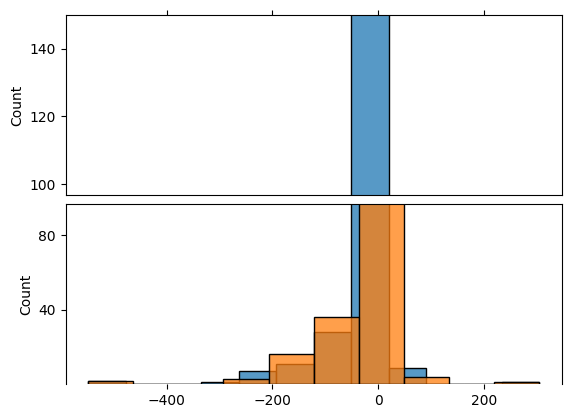

In [93]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # Adjust space between axes

# Plot the same data on both axes
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax1)  # Adjust bins as needed
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax2)  # Adjust bins as needed

# Get the second-highest frequency
greatest_y_lower_plot = 1.1 * second_highest_frequency(n_tauts_diff)

# Set y-axis limits on both subplots
# max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax1).get_yticks()[1:])
ax2.set_ylim(0, greatest_y_lower_plot)

# Adjust the y-axis limit on the second plot to create a break
max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax2).get_yticks()[1:])
ax1.set_ylim(greatest_y_lower_plot, max_val * 1.5)  # Adjust the range for the second plot

# Hide the overlapping portion of the y-axis between the two plots
ax2.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Hide top x-axis labels on the first plot

# Set the y-axis break indicator line
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))

plt.show()

In [51]:
def align_lists(
        list1,
        list2,
        filler = "",
):
    """Align list2 under list1, using filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  b,  c
    list2: a,  d,  c,  e,  f

    output:
    list2: a, "",  c,  d,  e,  f
    """
    # Determine index for each element in list2:
    list_2_indices = []
    list2_index_max = len(list1) - 1
    for _, list2_item in enumerate(list2):
        try:
            list2_index = list1.index(list2_item)
        except:
            list2_index_max += 1
            list2_index = list2_index_max
        list_2_indices.append(list2_index)

    # Create "empty" (all filler) list2 aligned--may be longer than list2 due to blank spaces
    list2_aligned = [filler] * (max(list_2_indices) + 1)

    # Slot in items from list2 to overwrite filler entries
    for i, list_2_col in enumerate(list_2_indices):
        list2_aligned[list_2_col] = list2[i]

    return list2_aligned

In [33]:
df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 73)
df_melted_aggregated_different_example

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[str],list[str],i64,i64,bool,i64
73,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x1338faf80>, <rdkit.Chem.rdchem.Mol object at 0x135890190>]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]","[[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""], [""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1""]]","[[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""], [""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]]","[""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1""]",4,8,false,-4


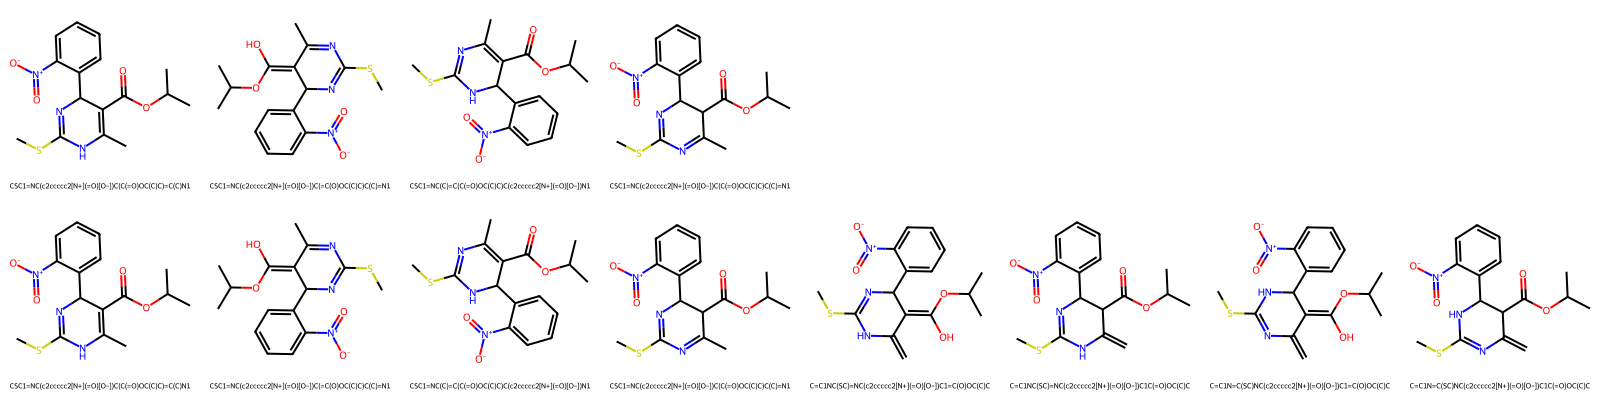

In [69]:
smls_v2 = df_melted_aggregated_different_example.select("flat_tautsTautomerEnumerator").item().to_list()
smls_v1 = df_melted_aggregated_different_example.select("flat_tautsGetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_lists(smls_v2, smls_v1)
tauts_v2 = [Chem.MolFromSmiles(sml) for sml in smls_v2]
tauts_v1_aligned = [Chem.MolFromSmiles(sml) for sml in smls_v1_aligned]

smls_matrix = [smls_v2, smls_v1_aligned]
tauts_matrix = [tauts_v2, tauts_v1_aligned]

tauts_all = tauts_v2 + tauts_v1_aligned

mcs = rdFMCS.FindMCS(tauts_all) #, **kwargs)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
mcs_mol
# z = ""
# for m in tauts_all:
#      _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
     # z = m
# z

Draw.MolsMatrixToGridImage(tauts_matrix, legendsMatrix=smls_matrix)

#TODO align maximum common substructure to make structures easier to compare visually

In [ ]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [Chem.MolFromSmiles(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

unique_InChI={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}
unique_smls_canon={'CC(=O)CC(C)=O', 'CC(=O)/C=C(/C)O'}
unique_smls_to_inchi={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}


Hi

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae8f0>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae960>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daae880>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x12daaea40>}]

In [ ]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec70>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaec00>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x12daaed50>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x12daaec70>, <rdkit.Chem.rdchem.Mol object at 0x12daaec00>], [<rdkit.Chem.rdchem.Mol object at 0x12daaedc0>, <rdkit.Chem.rdchem.Mol object at 0x12daaed50>]]


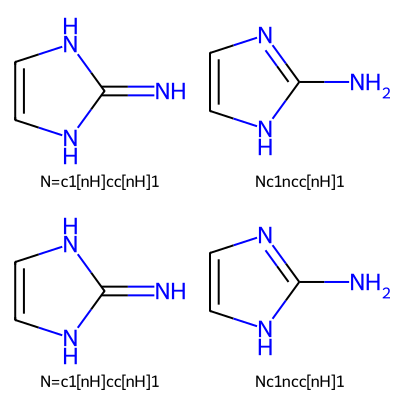

In [ ]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)